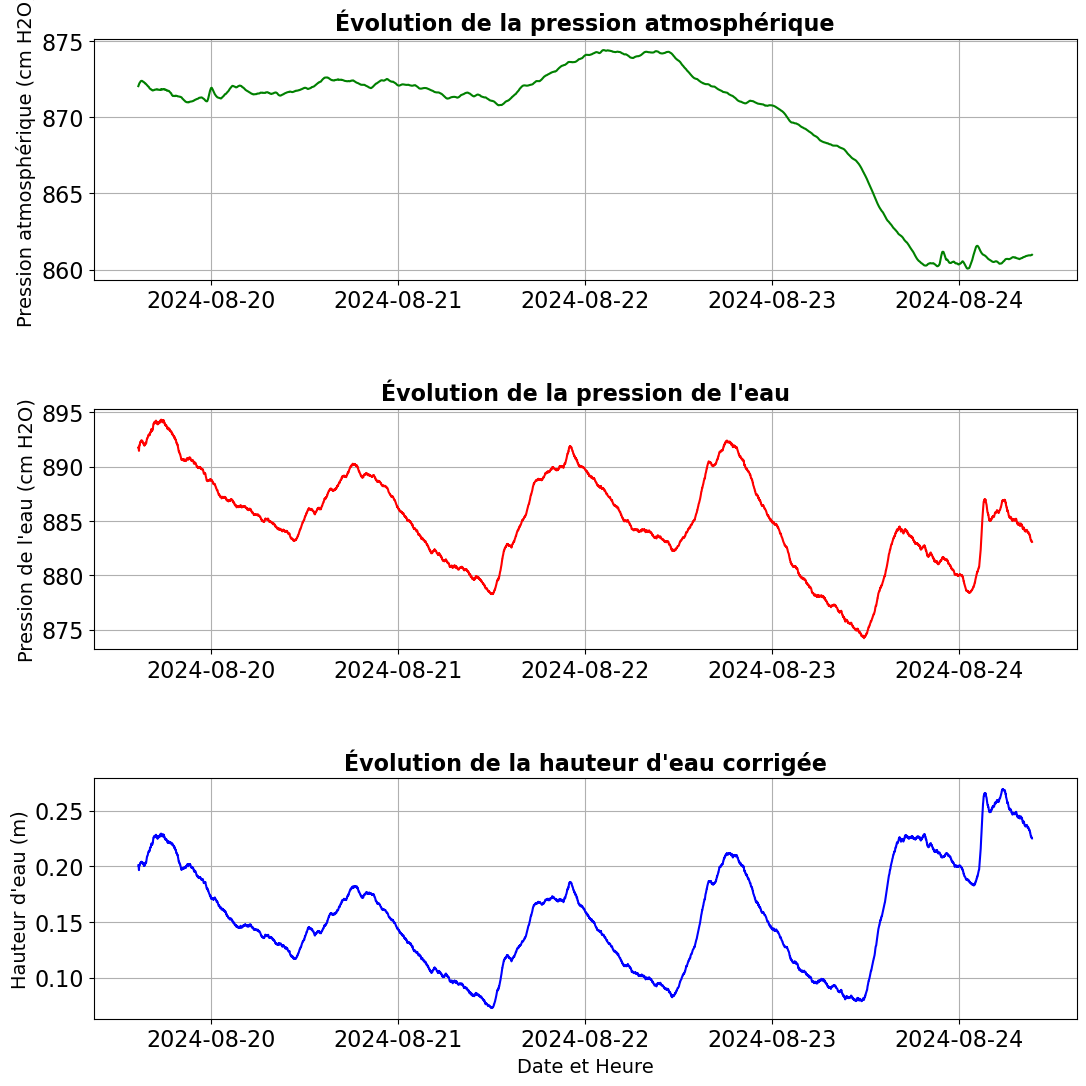

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data file
file_path = r"D:\UQTR\Automne 2024\Ouest\Hydro\Calculated_Water_Height_with_Predicted_Discharge.xlsx"
data = pd.read_excel(file_path)

# Convert 'DateTime' to datetime format and select relevant columns
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
data = data[['DateTime', 'AirPressure_cmH2O', 'WaterPressure_cmH2O', 'WaterHeight_m']].dropna()

# Apply a rolling mean for smoothing (adjust window size as needed)
window_size = 30  # You can increase this for more smoothing
data['AirPressure_Smoothed'] = data['AirPressure_cmH2O'].rolling(window=window_size, center=True).mean()
data['WaterPressure_Smoothed'] = data['WaterPressure_cmH2O'].rolling(window=window_size, center=True).mean()
data['WaterHeight_Smoothed'] = data['WaterHeight_m'].rolling(window=window_size, center=True).mean()

# Plotting the smoothed data in a 3-row layout
plt.figure(figsize=(12, 12))

# Atmospheric pressure in water plot (smoothed)
plt.subplot(3, 1, 1)
plt.plot(data['DateTime'], data['AirPressure_Smoothed'], color='green')
plt.title("Évolution de la pression atmosphérique", fontsize=16, fontweight='bold')
plt.ylabel("Pression atmosphérique (cm H2O)", fontsize=14)
plt.grid(True)

# Water pressure plot (smoothed)
plt.subplot(3, 1, 2)
plt.plot(data['DateTime'], data['WaterPressure_Smoothed'], color='red')
plt.title("Évolution de la pression de l'eau", fontsize=16, fontweight='bold')
plt.ylabel("Pression de l'eau (cm H2O)", fontsize=14)
plt.grid(True)

# Corrected water height plot (smoothed)
plt.subplot(3, 1, 3)
plt.plot(data['DateTime'], data['WaterHeight_Smoothed'], color='blue')
plt.title("Évolution de la hauteur d'eau corrigée", fontsize=16, fontweight='bold')
plt.xlabel("Date et Heure", fontsize=14)
plt.ylabel("Hauteur d'eau (m)", fontsize=14)
plt.grid(True)

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()


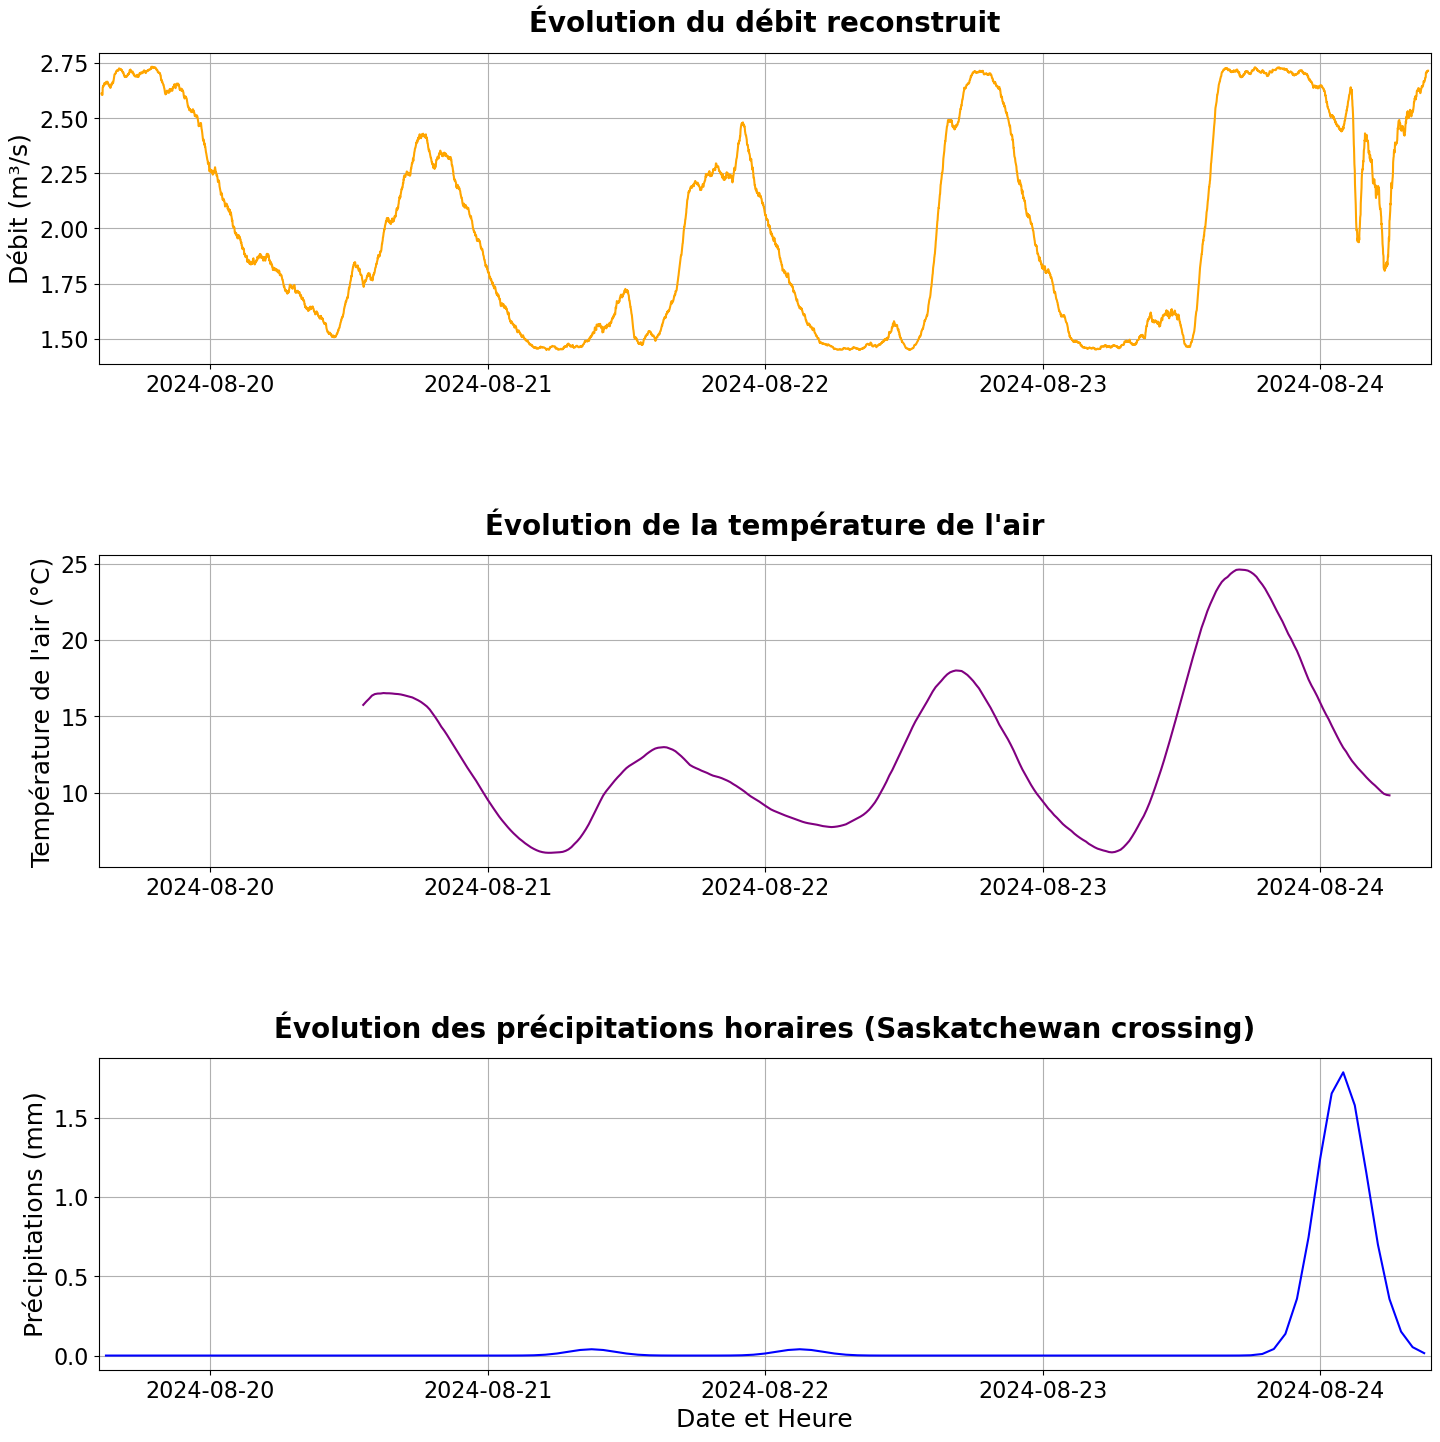

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.dates as mdates

# Charger les données de débit
file_path = r"D:\UQTR\Automne 2024\Ouest\Hydro\Calculated_Water_Height_with_Predicted_Discharge.xlsx"
file_path_temperature = r"D:\UQTR\Automne 2024\Ouest\geo1113_2024_data\geo1113_2024_data\Météorologie\hobo0\Hobo0.csv"
file_path_precipitation = r"D:\Downloads\ACISHourlyData-20240819-20240824-PID135314885.csv"

# Débit
data = pd.read_excel(file_path)
data['DateTime'] = pd.to_datetime(data['DateTime'], errors='coerce')
data = data[['DateTime', 'Débit (m³/s) prédit']].dropna()
window_size = 30
data['Smoothed_Debit'] = data['Débit (m³/s) prédit'].rolling(window=window_size, center=True).mean()

# Température de l'air
temperature_data = pd.read_csv(file_path_temperature, delimiter=';', skiprows=1)
temperature_data = temperature_data[['Date Time, GMT-06:00', 'Temp, °C (LGR S/N: 20472582, SEN S/N: 20472582)']]
temperature_data.columns = ['DateTime', 'Air_Temperature']
temperature_data['DateTime'] = pd.to_datetime(temperature_data['DateTime'], errors='coerce')
temperature_data['Air_Temperature'] = pd.to_numeric(temperature_data['Air_Temperature'], errors='coerce')
temperature_data = temperature_data.dropna().sort_values(by='DateTime')
temperature_data['Smoothed_Air_Temperature'] = temperature_data['Air_Temperature'].rolling(window=window_size, center=True).mean()

# Précipitations
precipitation_data = pd.read_csv(file_path_precipitation, delimiter=';')
precipitation_data['Date (Local Standard Time)'] = pd.to_datetime(precipitation_data['Date (Local Standard Time)'])
precipitation_data['Precip. (mm)'] = pd.to_numeric(precipitation_data['Precip. (mm)'], errors='coerce')
precipitation_data['Smoothed_Precipitation'] = gaussian_filter1d(precipitation_data['Precip. (mm)'].fillna(0), sigma=2)

# Get date range from discharge data
start_date = data['DateTime'].min()
end_date = data['DateTime'].max()

# Filter temperature data to match discharge date range
temperature_data = temperature_data[
    (temperature_data['DateTime'] >= start_date) & 
    (temperature_data['DateTime'] <= end_date)
]

# Filter precipitation data
precipitation_data = precipitation_data[
    (precipitation_data['Date (Local Standard Time)'] >= start_date) & 
    (precipitation_data['Date (Local Standard Time)'] <= end_date)
]

# Reapply smoothing to filtered data
temperature_data['Smoothed_Air_Temperature'] = temperature_data['Air_Temperature'].rolling(
    window=window_size, center=True).mean()

# Create figure with same size
plt.figure(figsize=(16, 16))

# Set even larger font sizes
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

# Format dates with explicit interval
date_format = mdates.DateFormatter('%Y-%m-%d')
locator = mdates.DayLocator(interval=1)  # Show ticks for every day

# Set same x-axis limits for all plots
x_min = start_date
x_max = end_date

# Débit reconstruit
ax1 = plt.subplot(3, 1, 1)
plt.plot(data['DateTime'], data['Smoothed_Debit'], color='orange')
plt.title("Évolution du débit reconstruit", fontsize=20, fontweight='bold', pad=15)
plt.ylabel("Débit (m³/s)", fontsize=18)
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.set_major_locator(locator)
ax1.set_xlim(x_min, x_max)
plt.xticks(rotation=0)
plt.grid(True)

# Température de l'air
ax2 = plt.subplot(3, 1, 2)
plt.plot(temperature_data['DateTime'], temperature_data['Smoothed_Air_Temperature'], color='purple')
plt.title("Évolution de la température de l'air", fontsize=20, fontweight='bold', pad=15)
plt.ylabel("Température de l'air (°C)", fontsize=18)
ax2.xaxis.set_major_formatter(date_format)
ax2.xaxis.set_major_locator(locator)
ax2.set_xlim(x_min, x_max)
plt.xticks(rotation=0)
plt.grid(True)

# Précipitations
ax3 = plt.subplot(3, 1, 3)
plt.plot(precipitation_data['Date (Local Standard Time)'], precipitation_data['Smoothed_Precipitation'], color='blue')
plt.title("Évolution des précipitations horaires (Saskatchewan crossing)", fontsize=20, fontweight='bold', pad=15)
plt.xlabel("Date et Heure", fontsize=18)
plt.ylabel("Précipitations (mm)", fontsize=18)
ax3.xaxis.set_major_formatter(date_format)
ax3.xaxis.set_major_locator(locator)
ax3.set_xlim(x_min, x_max)
plt.xticks(rotation=0)
plt.grid(True)

# Adjust layout
plt.tight_layout(h_pad=5.0, pad=4.0)
plt.show()


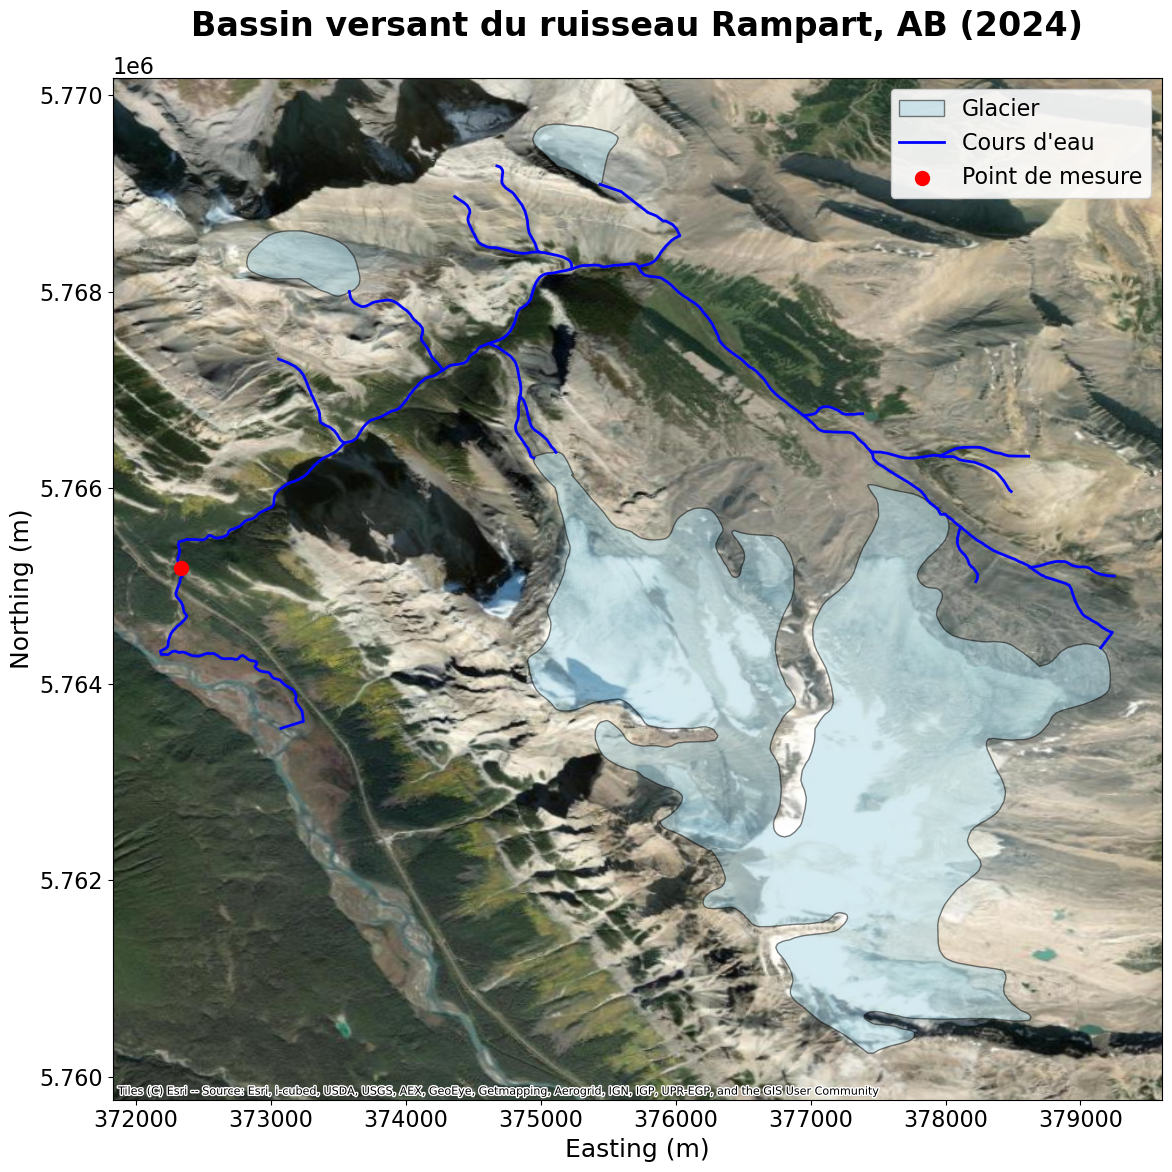

In [37]:
import fiona
from shapely.geometry import shape
from shapely.ops import transform
import pyproj
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Load the shapefile for the glacier
shapefile_path = r"D:\UQTR\Automne 2024\Ouest\Hydro\OneDrive_1_01-11-2024\glacier.shp"
glacier_shapes = []

with fiona.open(shapefile_path, "r") as shapefile:
    for feature in shapefile:
        glacier_shapes.append(shape(feature["geometry"]))

# Load the shapefile for the Ruisseau
ruisseau_shapefile_path = r"D:\UQTR\Automne 2024\Ouest\Hydro\OneDrive_1_01-11-2024\Ruisseau.shp"
ruisseau_shapes = []

with fiona.open(ruisseau_shapefile_path, "r") as shapefile:
    for feature in shapefile:
        ruisseau_shapes.append(shape(feature["geometry"]))

# Load the shapefile for points
point_shapefile_path = r"D:\UQTR\Automne 2024\Ouest\Hydro\OneDrive_2_01-11-2024\point.shp"
point_shapes = []

with fiona.open(point_shapefile_path, "r") as shapefile:
    for feature in shapefile:
        point_shapes.append(shape(feature["geometry"]))

# Get the CRS from the shapefile metadata
with fiona.open(shapefile_path, "r") as shapefile:
    original_crs = shapefile.crs

# No reprojection needed - keep original UTM coordinates

# Set larger font sizes
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

# Set up figure and axis
fig, ax = plt.subplots(figsize=(12, 12))

# Plot glacier shapes
for glacier_shape in glacier_shapes:
    if glacier_shape.geom_type == 'Polygon':
        x, y = glacier_shape.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightblue', edgecolor='black', label='Glacier' if 'Glacier' not in ax.get_legend_handles_labels()[1] else "")
    elif glacier_shape.geom_type == 'MultiPolygon':
        for polygon in glacier_shape.geoms:
            x, y = polygon.exterior.xy
            ax.fill(x, y, alpha=0.5, fc='lightblue', edgecolor='black', label='Glacier' if 'Glacier' not in ax.get_legend_handles_labels()[1] else "")

# Plot ruisseau shapes
for ruisseau_shape in ruisseau_shapes:
    if ruisseau_shape.geom_type == 'LineString':
        x, y = ruisseau_shape.xy
        ax.plot(x, y, color='blue', linewidth=2, label='Cours d\'eau' if 'Cours d\'eau' not in ax.get_legend_handles_labels()[1] else "")
    elif ruisseau_shape.geom_type == 'Polygon':
        x, y = ruisseau_shape.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='cyan', edgecolor='darkblue', label='Plan d\'eau' if 'Plan d\'eau' not in ax.get_legend_handles_labels()[1] else "")
    elif ruisseau_shape.geom_type == 'MultiLineString':
        for line in ruisseau_shape.geoms:
            x, y = line.xy
            ax.plot(x, y, color='blue', linewidth=2, label='Cours d\'eau' if 'Cours d\'eau' not in ax.get_legend_handles_labels()[1] else "")

# Plot point shapes
for point_shape in point_shapes:
    if point_shape.geom_type == 'Point':
        x, y = point_shape.x, point_shape.y
        ax.scatter(x, y, c='red', s=100, zorder=5,
                   label='Point de mesure' if 'Point de mesure' not in ax.get_legend_handles_labels()[1] else "")
    elif point_shape.geom_type == 'MultiPoint':
        for point in point_shape.geoms:
            x, y = point.x, point.y
            ax.scatter(x, y, c='red', s=100, zorder=5,
                       label='Point de mesure' if 'Point de mesure' not in ax.get_legend_handles_labels()[1] else "")

# Set axis labels to UTM coordinates
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')

# Set title with larger, bold font
ax.set_title("Bassin versant du ruisseau Rampart, AB (2024)",
             pad=30,
             fontsize=24,
             fontweight='bold')

# Add satellite basemap
ctx.add_basemap(ax, 
                source=ctx.providers.Esri.WorldImagery,
                crs=original_crs)  # Use original UTM CRS

# Add legend
ax.legend(loc='upper right', frameon=True, facecolor='white', framealpha=0.9)

# Adjust layout
plt.tight_layout()
plt.show()